### Модуль 7. Финансовый аналитик

### Цель задания

Сегодня ты “Финансовый аналитик” - изучи и проанализируй внутренние финансы компании и финансовые показатели партнеров, конкурентов или стартапов, в которые компания хочет инвестировать.В частности: макроэкономические и микроэкономические условия наряду с фундаментальными показателями компании.Рекомендуй курс действий для руководства по покупке или продаже акций компании, исходя из ее общих показателей и перспектив. Проведи критический анализ архитектуры DataLake.

### Навыки

|Архитектура|Базы данных|Форматы данных|Инструменты|Коммуникации|
|-----------|-----------|--------------|-----------|------------|
|Событийная|GreenPlum|DeltaLake|Обучение  с подкреплением AsyncioRED Dagster Стандарт AsyncAPI Безопасность модели|Все отделы компании, банки|


### Условия

Можно пользоваться любыми языковыми моделями

###  Формат сдачи и отправка задания

Итоговый блокнот нужно разместить на GitLab либо на GitHub ("запушить" в любом формате .py или .ipynb)
и поделиться ссылкой на файл (убедившись, что видимости репозитория).

###  Сроки выполнения задания

Максимум одна неделя, сданные после истечения максимального срока  работы не проверяются.

###  Критерии оценивания

| Критерий                 | Вес | Описание                                                                                                                                                                                              |
|--------------------------|-----|----------------------------------------------------------|
| Выбор алгоритма          | 15% | Оценка уместности выбранного алгоритма для данной задачи.|
| Точность реализации      | 15% | Оценка корректности реализации алгоритма.                |
| Основная функциональность| 20% | Оценка степени выполнения основных требований задания.   |
| Обработка крайних случаев| 10% | Оценка кода по обработке граничных входных данных.       |
| Документация к коду      | 10% | Оценка ясности и полноты комментариев в коде.            |
| Объяснение результатов   | 10% | Оценка четкости объясненния результатов работы кода      |
| Стиль кода               | 10% | Оценка читаемости кода и соответствия PEP-8              |
| Анализ ошибок и отладка  | 10% | Оценка способности студента выявлять и исправлять ошибки |


**Максимальный балл за выполненную домашнюю работу: 10 баллов**

**Дополнительные условия оценки:**

Можно сдать работу через обычный Google Colab без начисления штрафных баллов и поделиться ссылкой на файл.

**Как будет проверяться:**

Работа будет проверяться преподавателем вручную в течение максимум одной недели.

### Задание №1

Подключи расширение RAPIDS cuDF командой ```%load_ext cudf.pandas``` и измерь ускорение работы pandas на графическом процессоре GPU


In [ ]:
%%capture
# установка занимает 3 минуты
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!pip install pandas gdown torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [5]:
import cudf
import pandas as pd
import gdown
url = "https://drive.google.com/uc?export=download&id=1HRajTCSQCaMJea_mrQKeSuI5BeLApgnT"
output = "Stock_Data.zip"
gdown.download(url, output)
!rm /content/all_stocks_5yr.csv -f
!unzip Stock_Data.zip
df = pd.read_csv("/content/all_stocks_5yr.csv", header = 0, sep = ',')
df.head(1)

Downloading...
From: https://drive.google.com/uc?export=download&id=1HRajTCSQCaMJea_mrQKeSuI5BeLApgnT
To: /content/Stock_Data.zip
100%|██████████| 10.1M/10.1M [00:00<00:00, 372MB/s]


Archive:  Stock_Data.zip
  inflating: all_stocks_5yr.csv      


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL


In [6]:
big_df = pd.concat([df]*250,ignore_index=True);big_df.info() # увеличенный в 250 раз набор данных занял почти всю памть

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 154760000 entries, 0 to 154759999
Data columns (total 7 columns):
 #   Column  Dtype
---  ------  -----
 0   date    object
 1   open    float64
 2   high    float64
 3   low     float64
 4   close   float64
 5   volume  int64
 6   Name    object
dtypes: float64(4), int64(1), object(2)
memory usage: 8.8+ GB


In [ ]:
%%time

(big_df
 .groupby(["Name"])
 .agg({"close": "mean"})
 .rename(columns={"close": "mean_close_price"})
 .sort_values(["mean_close_price"], ascending=False)
) #обрабатываем 154 миллиона строк на CPU за 17 сек

CPU times: user 11.2 s, sys: 6.01 s, total: 17.2 s
Wall time: 18 s


,mean_close_price
Name,
PCLN,1312.873538
GOOG,725.403353
GOOGL,682.233847
AZO,619.703654
AMZN,576.880041
...,...
CHK,13.681326
AES,12.340048
RF,10.935608


In [4]:
# Подключаем расширение для ускорения pandas с помощью cuDF
%load_ext cudf.pandas

In [9]:
import torch

print(f"Доступно GPU: {torch.cuda.is_available()}")
print(f"Количество GPU: {torch.cuda.device_count()}")
print(f"Имя GPU: {torch.cuda.get_device_name()}")

Доступно GPU: True
Количество GPU: 1
Имя GPU: Tesla T4


In [7]:
%%time

(big_df
 .groupby(["Name"])
 .agg({"close": "mean"})
 .rename(columns={"close": "mean_close_price"})
 .sort_values(["mean_close_price"], ascending=False)
) #обрабатываем 154 миллиона строк на GPU за 0,4 сек

CPU times: user 186 ms, sys: 161 ms, total: 347 ms
Wall time: 465 ms


,mean_close_price
Name,
PCLN,1312.873538
GOOG,725.403353
GOOGL,682.233847
AZO,619.703654
AMZN,576.880041
...,...
CHK,13.681326
AES,12.340048
RF,10.935608


### Задание №2

Инжиниринг признаков — это создание новых признаков на основе существующих признаков. Создадим новый признак "день недели" из колонки "date". Подтверди или опровергни гипотезу о том, что день недели влияет на объём торгов (одной любой акции на свой выбор)

In [ ]:
df['timestamp'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Извлекаем день недели (0=понедельник, 6=воскресенье)
df.head(1) # датафрейм с новым признаком

,date,open,high,low,close,volume,Name,timestamp,day_of_week
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2013-02-08,4


In [ ]:
# Подгрузка библиотек и разделение выборки

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Выбираем данные по акции AAL
aal_df = df[df['Name'] == 'AAL'].copy()

aal_df.head(3)

,date,open,high,low,close,volume,Name,timestamp,day_of_week
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2013-02-08,4
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,2013-02-11,0
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,2013-02-12,1


In [ ]:
# Группируем по дню недели и считаем средний объем торгов
volume_by_day = aal_df.groupby('day_of_week')['volume'].mean()
volume_by_day

,volume
day_of_week,
0,8.622585e+06
1,9.378865e+06
2,9.484905e+06
3,9.311117e+06
4,1.010312e+07


In [ ]:
# Метки для дней недели в данных
days_in_data = sorted(volume_by_day.index)
days_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
available_labels = [days_labels[i] for i in days_in_data]

available_labels

['Пн', 'Вт', 'Ср', 'Чт', 'Пт']

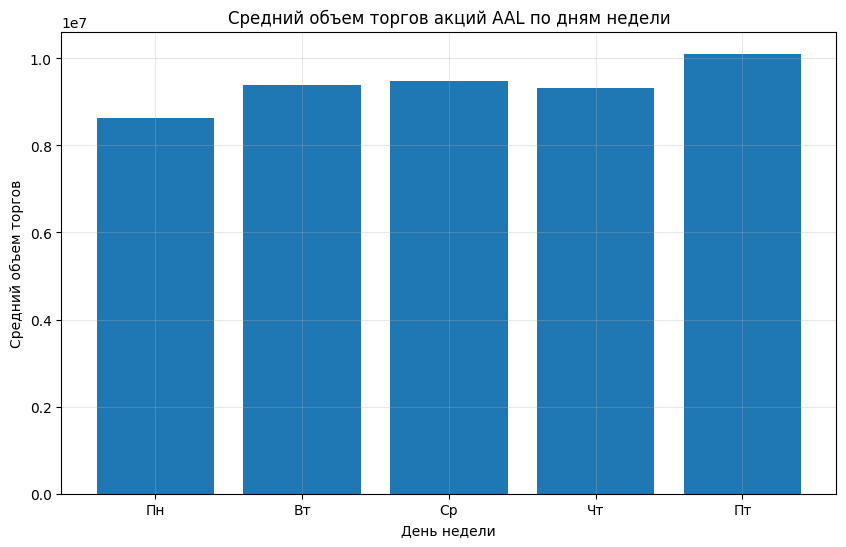

In [ ]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.bar(available_labels, volume_by_day.values)
plt.title('Средний объем торгов акций AAL по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средний объем торгов')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Формирование гипотезы
# H0: cредние объёмы торгов не зависят от дня недели
# H1: день недели влияет на cредние объёмы торгов

In [ ]:
volume_per_day = [group['volume'].values for _, group in aal_df.groupby('day_of_week')]

# Проводим ANOVA тест
f_stat, p_value = stats.f_oneway(*volume_per_day)

print(f"f-stat = {f_stat:.2f}")
print(f"p-value = {p_value:.4f}")

f-stat = 1.43
p-value = 0.2232


In [ ]:
# При p-value = 0.2232 отказываемся от H1 гипотезы (опровергнута, нет статзначимого влияния дня недели)

### Задание №3

Рассчитай технический индикатор "полосы Боллинджера" по имеющимся (хранящимся, статическим) данным

In [ ]:
#!pip install TA-Lib-Precompiled  numpy==1.26.4 - установка завершается с ошибкой
!pip install TA-Lib  numpy==1.26.4

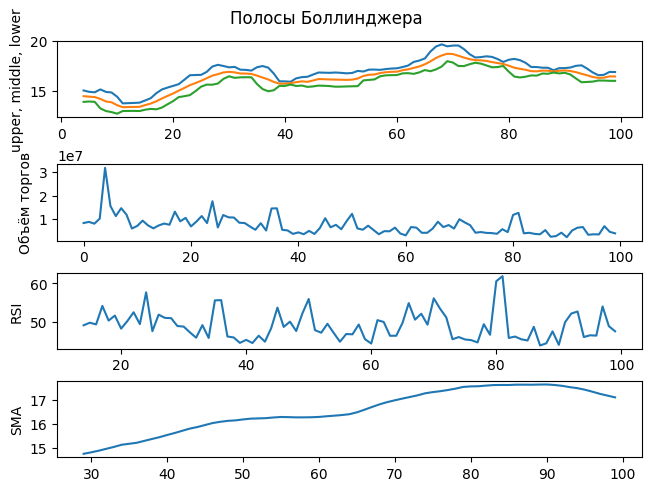

In [ ]:
import talib
import numpy as np
from talib import MA_Type
import matplotlib.pyplot as plt

#print ("Список всех индикаторов\n","\n".join(talib.get_functions()))

df = df[:100]
rsi = talib.RSI(np.array(df["volume"], dtype=np.float64))
outputSMA = talib.SMA(np.array(df["close"], dtype=np.float64))
upper, middle, lower = talib.BBANDS(
# построй полосы Боллинджера по массиву np.array(df["close"], dtype=np.float64), используй функцию talib.BBANDS
    np.array(df["close"], dtype=np.float64),
    timeperiod=5,
    nbdevup=2,
    nbdevdn=2,
    matype=MA_Type.SMA
)
t = range(0, len(df["volume"]))

fig, axs = plt.subplots(4, 1, layout='constrained')
axs[0].plot(t, upper+0.03, t, middle,t,lower-0.03)
axs[0].set_ylabel('upper, middle, lower')
#axs[0].grid(True)
plt.suptitle("Полосы Боллинджера")
axs[1].plot(range(0, len(df["volume"])),df["volume"])
axs[1].set_ylabel('Объём торгов')
axs[2].plot(range(0, len(df["volume"])),rsi)
axs[2].set_ylabel('RSI')
axs[3].plot(range(0, len(df["volume"])),outputSMA)
axs[3].set_ylabel('SMA')
plt.show()

### Задание №4

Рассчитай технический индикатор "скользящая средняя" по потоковым (только полученным, свежим) данным используя  Streaming API

In [ ]:
%%capture
!pip install 'python-engineio==3.14.2'
!pip install 'python-socketio==4.3.1'

In [ ]:
from talib import stream

close = np.array(df["close"], dtype=np.float64)

output = talib.SMA(close) # the Function API для статических данных
latest = stream.SMA(close) # the Streaming API <- используй потоковый API
print ("статические данные ",output[-1], ", потоковые данные ", latest)

статические данные  17.115999999999996 , потоковые данные  17.116


In [ ]:
import socketio
import time

# standard Python
sio = socketio.Client()

@sio.event
def connect():
    print("I'm connected!")
    sio.emit('login', {'userKey': 'wsfQsXX90onvUpylWgzQ'})

@sio.event
def connect_error():
    print("The connection failed!")

@sio.event
def message(data):
    print('I received a message!')

@sio.on('handshake')
def on_message(data):
    print('HandShake', data)
    sio.emit('symbolSub', {'symbol': 'EURUSD'})

@sio.on('price')
def on_message(data):
    # напиши здесь код, использующий потоковый API stream.SMA

    close_prices = []
    SMA_PERIOD = 10


    try:
        # Получаем цену закрытия из потоковых данных
        if 'bid' in data and data['bid'] is not None:
            current_price = float(data['bid'])

            # Добавляем новую цену в список
            close_prices.append(current_price)

            # Поддерживаем только последние N цен для расчета SMA
            if len(close_prices) > SMA_PERIOD:
                close_prices.pop(0)  # Удаляем самую старую цену

            # Рассчитываем скользящую среднюю на потоковых данных
            if len(close_prices) >= SMA_PERIOD:
                # Конвертируем в numpy array для использования с TA-Lib
                prices_array = np.array(close_prices, dtype=np.float64)

                # Используем Streaming API для расчета SMA
                current_sma = stream.SMA(prices_array, timeperiod=SMA_PERIOD)

                # Выводим результаты
                print(f"Текущая цена: {current_price:.5f}")
                print(f"Скользящая средняя ({SMA_PERIOD}): {current_sma:.5f}")

                # Торговые сигналы на основе SMA
                if current_price > current_sma:
                    print("Цена выше скользящей средней")
                elif current_price < current_sma:
                    print("Цена ниже скользящей средней")
                else:
                    print("Цена на уровне скользящей средней")

                print("-" * 50)

            else:
                print(f"Собираем данные... ({len(close_prices)}/{SMA_PERIOD})")

    except Exception as e:
        print(f"Ошибка при обработке данных: {e}")



    # напиши здесь код, использующий потоковый API stream.SMA
    print('Price Data ', data)

@sio.event
def disconnect():
    print('disconnected from server')

sio.connect('https://marketdata.tradermade.com')
time.sleep(30)
sio.disconnect()
time.sleep(3)


I'm connected!


### Задание №5

Современный оркестратор Dagster.io даёт возможность **реактивно** запускать следующий этап конвейера данных (при изменении данных предыдущего этапа) используя [Сенсор](https://docs.dagster.io/guides/automate/asset-sensors).

Подключи Сенсор к функции daily_sales_data_sensor, реагирующий на изменение "daily_sales_data" и запускающий обновление weekly_report

In [ ]:
%%capture
!pip install dagster dagster-dg-cli

In [ ]:
import dagster as dg
from datetime import datetime

@dg.asset(description="ежедневный отчёт по стоимости чистых активов ПИФа")
def daily_sales_data(context: dg.AssetExecutionContext):
    context.log.info("Запускаю ежедневный отчёт СЧА")
    yield dg.MaterializeResult(value=df[-1:]["close"].to_list(),metadata={"отчёт СЧА на дату": datetime.now().isoformat()})


@dg.asset(description="еженедельный отчёт по стоимости чистых активов ПИФа")
def weekly_report(context: dg.AssetExecutionContext):
    context.log.info("Еженедельный отчёт СЧА готов")
    yield dg.MaterializeResult(metadata={"Еженедельный отчёт СЧА на дату": datetime.now().isoformat()})


my_job = dg.define_asset_job("Обновление еженедельного отчёта СЧА", [weekly_report])

#нужно подключить Сенсор к этой функции

@dg.asset_sensor(
    asset_key=dg.AssetKey("daily_sales_data"),
    job=my_job
)

def daily_sales_data_sensor(context: dg.SensorEvaluationContext, asset_event):
    # asset_event передается при материализации daily_sales_data
    context.log.info(f"Обнаружено обновление daily_sales_data: {asset_event}")

    # Запускаем обновление weekly_report
    yield dg.RunRequest(
        run_key=f"weekly_report_{asset_event.event_log_entry.timestamp}",
        tags={
            "triggered_by": "daily_sales_data_sensor",
            "source_asset": "daily_sales_data"
        }
    )


print([_ for _ in daily_sales_data(None)],
      "\n",
[_ for _ in weekly_report(None)])

2025-10-26 21:50:47 +0000 - dagster - INFO - system - Запускаю ежедневный отчёт СЧА
2025-10-26 21:50:47 +0000 - dagster - INFO - system - Еженедельный отчёт СЧА готов


[MaterializeResult(asset_key=None, metadata={'отчёт СЧА на дату': '2025-10-26T21:50:47.357598'}, check_results=[], data_version=None, tags=None, value=[16.43])] 
 [MaterializeResult(asset_key=None, metadata={'Еженедельный отчёт СЧА на дату': '2025-10-26T21:50:47.430716'}, check_results=[], data_version=None, tags=None, value=<class 'dagster._core.definitions.utils.NoValueSentinel'>)]
